# Collection Method Confounder Analysis

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 21APR2021 

To check if there is any statistical significance for the 7-marker selected between RCC Urine samples collection in the clinic _vs._ operating room.


In [ ]:
# Global seed
import random  
random.seed(42)

#import os
#os.environ['PYTHONHASHSEED']=str(42)

import pandas as pd
import numpy as np
np.random.seed(42)
from matplotlib import pyplot as plt
from matplotlib import style

#For Seaborn plots
import seaborn as sns; sns.set(style='white')
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)
import scipy
import statsmodels as sms
from statsmodels.stats import multitest

In [ ]:
combined = pd.read_excel('combined.xlsx', index_col=0)

In [ ]:
RCC_cohort = combined[combined['Groups'] == 'RCC'] # Select only RCC samples.   

In [ ]:
# remove all non-metabolomic features expect collection/
Table = RCC_cohort.drop(['Sample ID', 'Patient ID', 'Gender',
                         'Race', 'BMI', 'Smoker', 'Age', 'Groups'], axis=1)

In [ ]:
# Use the collection column to generate clinic and OR dataframe
clinic = Table[Table['Collection'] == 'Clinic']
OR = Table[Table['Collection'] == 'OR']

In [ ]:
# Drop the last non-metabolomic features from the dataframes.
clinic.drop(['Collection'], axis=1, inplace=True)
OR.drop(['Collection'], axis=1, inplace=True)

Significance Testing: _t_-Test

In [ ]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

In [ ]:
# '''List of final metabolites set'''
ttest_result = Ttest(clinic.columns, clinic, OR, alpha=0.05, var=True)

# '''List of Statistically relevant metabolites'''
# Select metabolites with <0.05 FDR
#stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]

# Select metabolites with <0.05 t-test
#stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
#print("The total number of significant metabolites/Features is: ", len(stat_sig))

In [ ]:
discriminating = [720, 1481, 2102, 3141, 3675, 3804, 3872, 4080, 6261, 6262, 6578, 6594, 5698, 'hippurate_4', 'Trigonellinamide_1', 'lactate', 'mannitol_1']
seven_marker = [720, 1481, 2102, 3804, 6262, 6578, 6594]

In [ ]:
# select the metabolomic ID of the 7 markers.
final_result = ttest_result.loc[ttest_result['Metabolite'].isin(discriminating)]

In [ ]:
final_result[['Metabolite', 'FDR p-value']]

,Metabolite,FDR p-value
2101,2102,0.049640
3871,3872,0.063507
7134,hippurate_4,0.173520
6261,6262,0.174397
6260,6261,0.177414
6577,6578,0.217064
719,720,0.263836
1480,1481,0.327336
5697,5698,0.439866
7140,Trigonellinamide_1,0.464327


### Plot Graph 

In [ ]:
biomarker_feat = RCC_cohort[discriminating]
biomarker_feat =(biomarker_feat - biomarker_feat.mean(axis=0))/biomarker_feat.std(axis=0) #autoscaling

In [ ]:
group_loc = RCC_cohort.columns.get_loc("Collection") #autoscaling
biomarker =  RCC_cohort.iloc[:, group_loc].to_frame().join(biomarker_feat)

In [ ]:
biomarker.columns[1:]

Index([                 720,                 1481,                 2102,
                       3141,                 3675,                 3804,
                       3872,                 4080,                 6261,
                       6262,                 6578,                 6594,
                       5698,        'hippurate_4', 'Trigonellinamide_1',
                  'lactate',         'mannitol_1'],
      dtype='object')

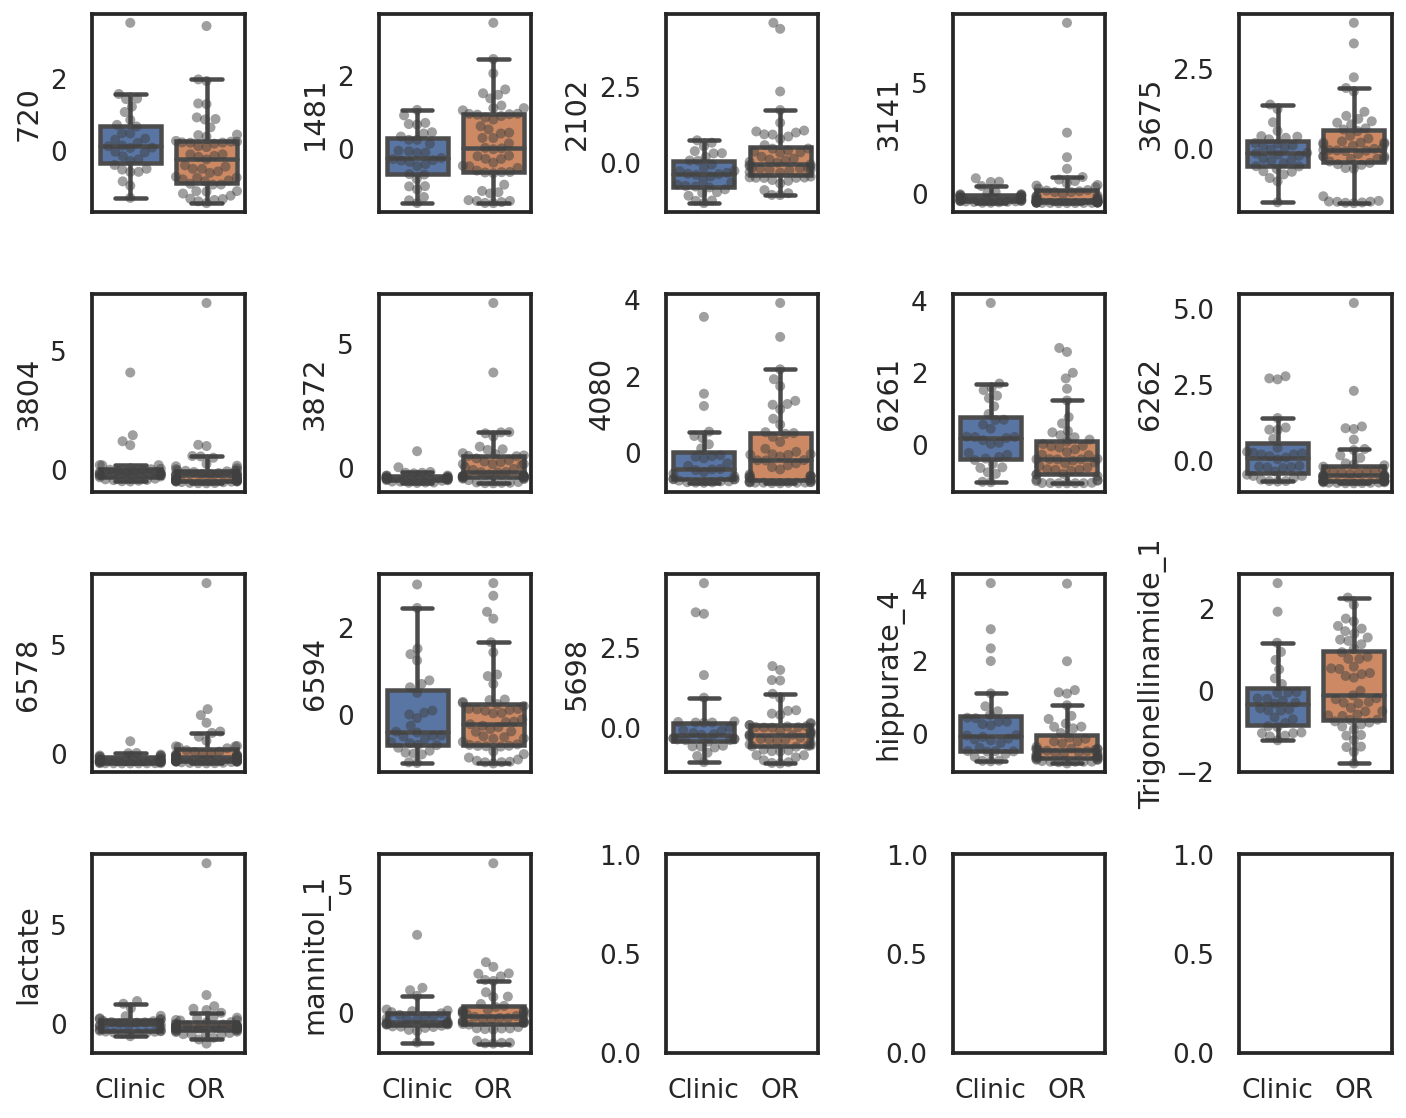

In [ ]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, figsize=(10, 8))
for idx, feat in enumerate(biomarker.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Collection', y=feat, data=biomarker, 
                ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Collection', y=feat, data=biomarker, 
                  ax=ax, s=5, alpha=0.5, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('OR_Clinic.svg', dpi=300)